# Exercise 2 - Solution


In [2]:
#import libraries
import numpy as np

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, load_digits
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline

## Task 1: k-Nearest Neighbours

In [3]:
#create dataset
N = 1000
N_train = int(N*0.9) #use 90% for training
N_test = N - N_train #rest for testing
x, y = make_moons(n_samples=N, noise=0.2,random_state=0)
#split into train and test set
xtrain, ytrain = x[:N_train,...], y[:N_train,...]
xtest, ytest = x[N_train:,...], y[N_train:,...]

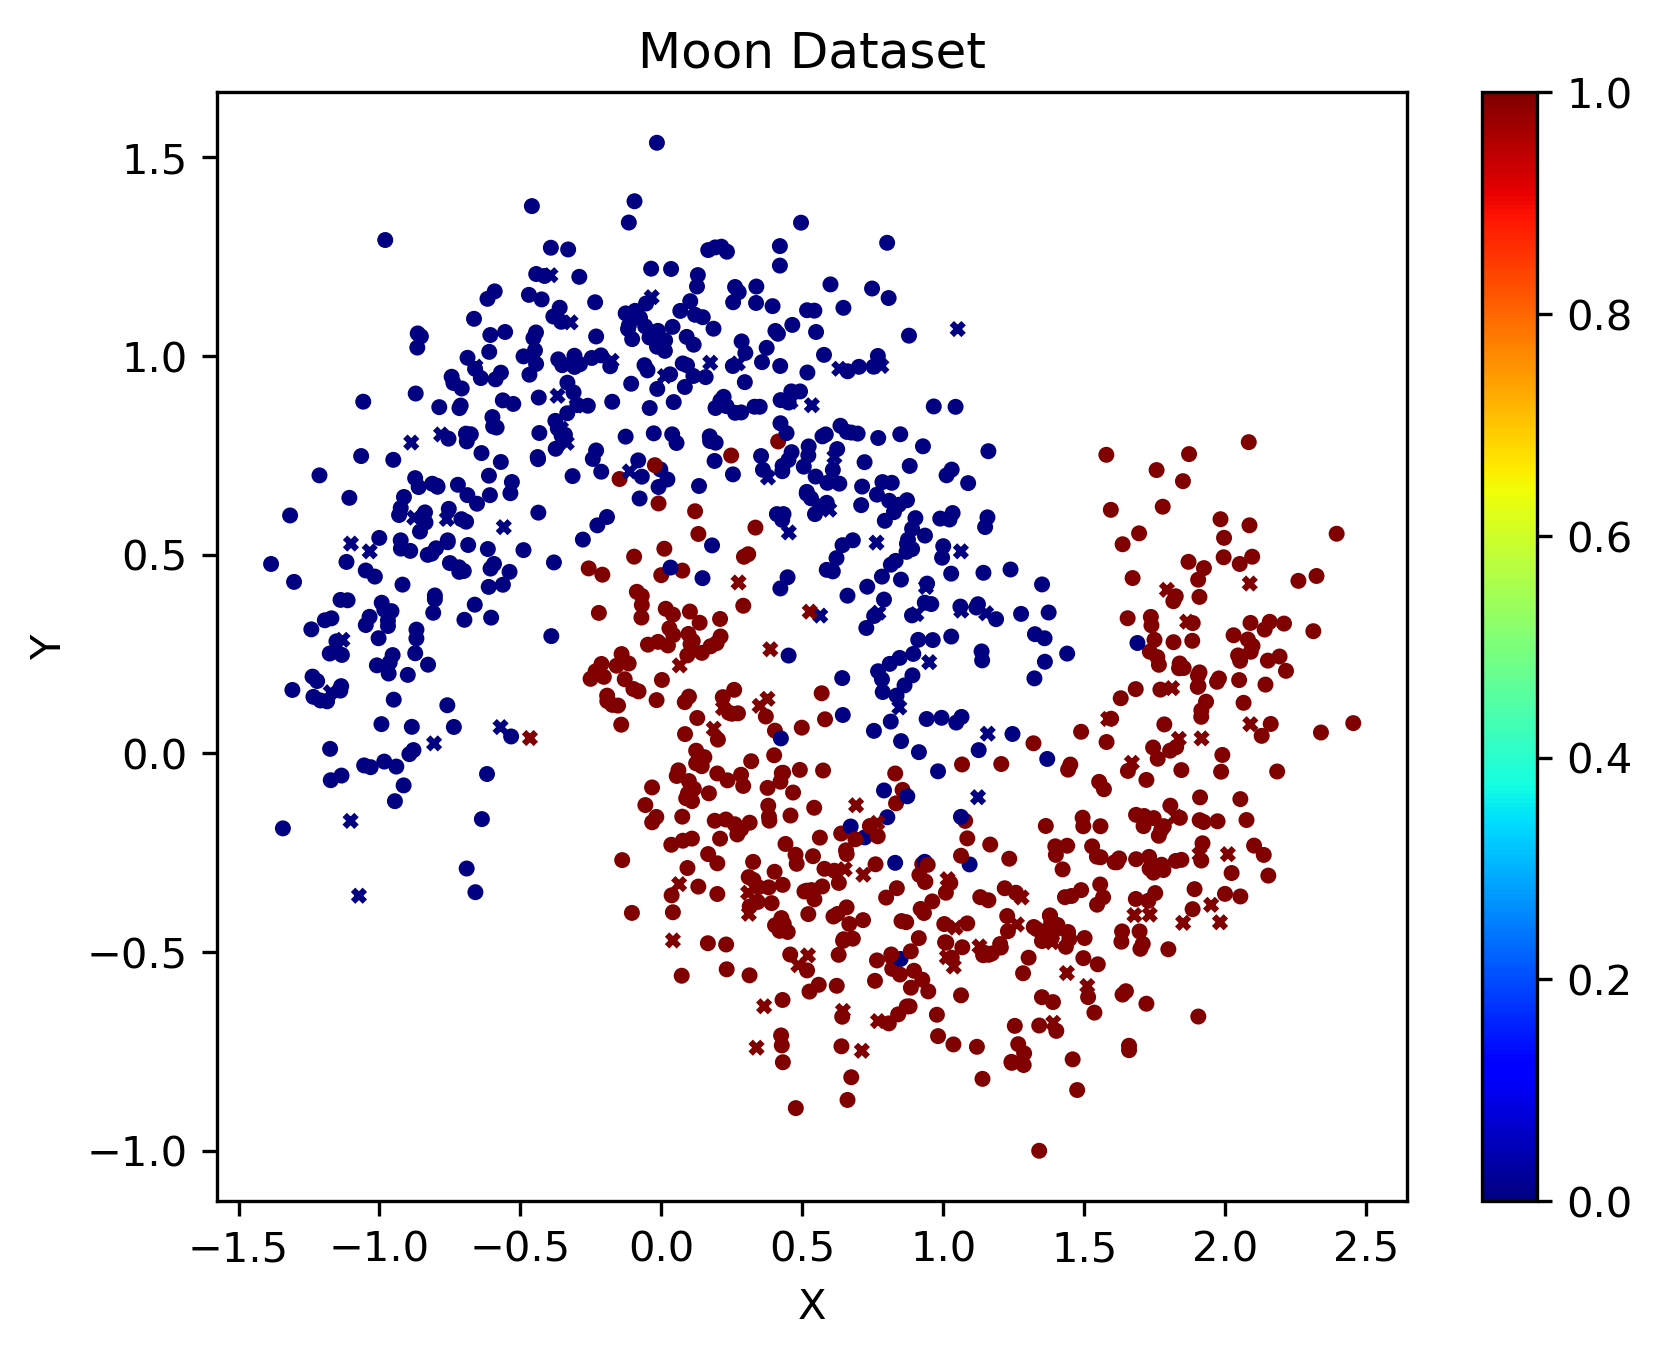

In [4]:
plt.figure(dpi=300)
plt.title("Moon Dataset")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(xtrain[:,0], xtrain[:,1], c=ytrain, marker="o", cmap=plt.cm.jet,s=8)
plt.scatter(xtest[:,0], xtest[:,1], c=ytest, marker="x", cmap=plt.cm.jet, s=8)
plt.colorbar()
plt.savefig("ex1_dataset.png")

In [5]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, x, y):
        #store training set for later prediction
        self.x = x
        self.y = y

    def kneighbours(self, q):
        #create distance matrix
        x = self.x[None,:,...]
        xq = q[:,None,...]
        dist_mat = np.sqrt(np.sum((x-xq)**2, axis=2))
        
        #sort by distance
        indices = np.argsort(dist_mat, axis=1)
        values = np.sort(dist_mat, axis=1)

        return indices[:,:self.k], values[:,:self.k]
    
    def predict(self, q):
        #get nearest point from training set
        indices, distances = self.kneighbours(q)
        classes = np.take(self.y, indices)

        #function for getting most frequent class from the k neighbours
        def most_common(row):
            vals, freqs = np.unique(row, return_counts=True)
            return vals[freqs.argmax()]

        pred = np.apply_along_axis(most_common, axis=1, arr=classes) #run most_common function along batch

        return pred

In [6]:
knn = KNN(5)
knn.fit(xtrain, ytrain)
pred = knn.predict(xtest)

knn2 = KNeighborsClassifier(5)
knn2.fit(xtrain, ytrain)
pred2 = knn2.predict(xtest)

#check if our implementation is equal to that one from scikit-learn
print("Are results equal: ", (pred == pred2).all())

Are results equal:  True


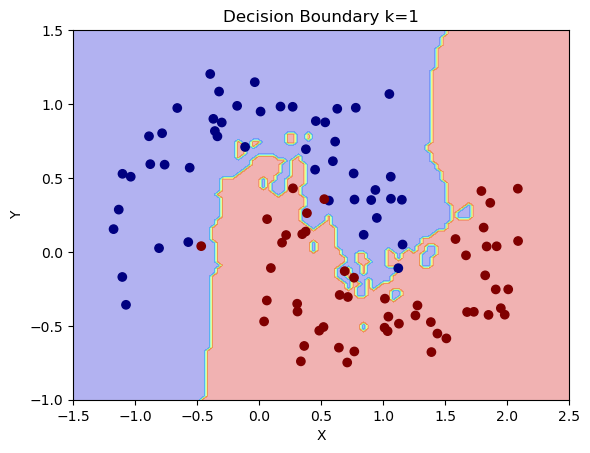

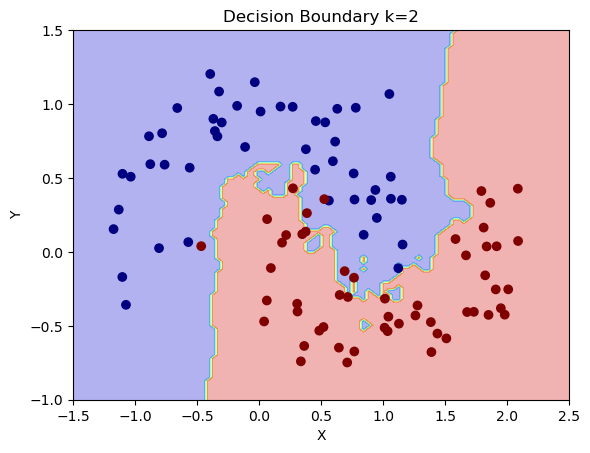

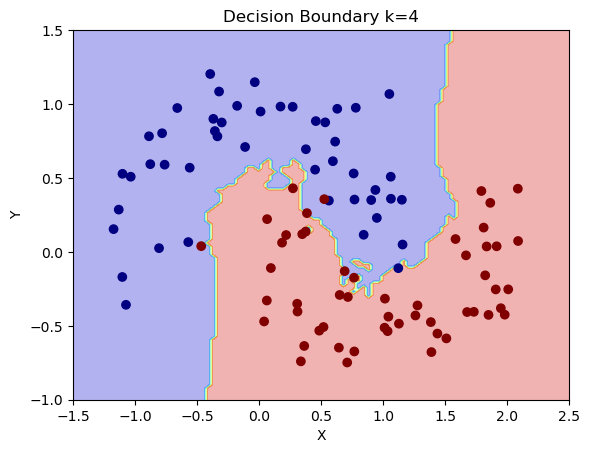

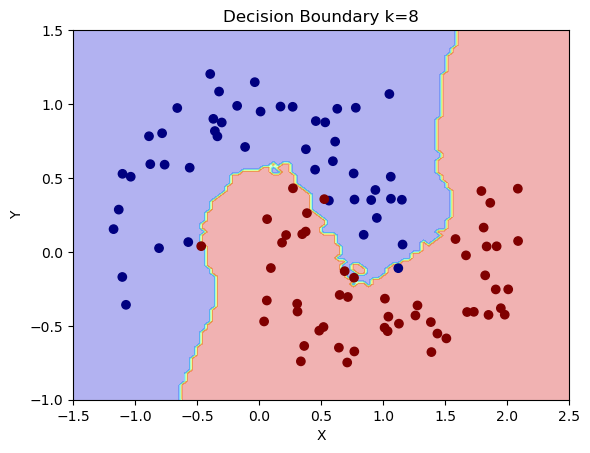

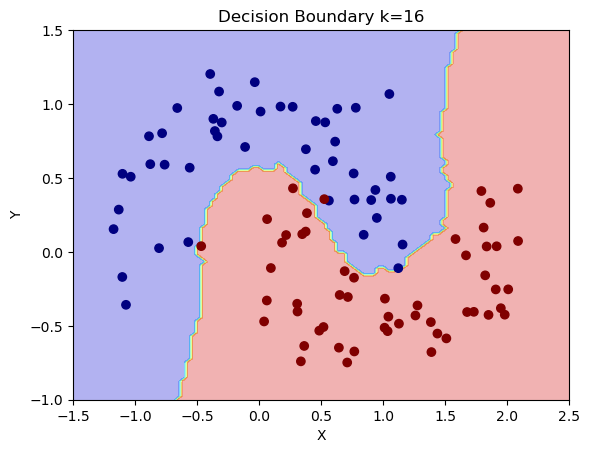

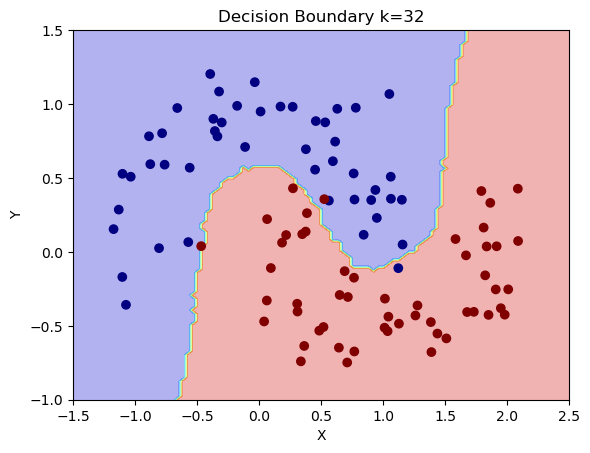

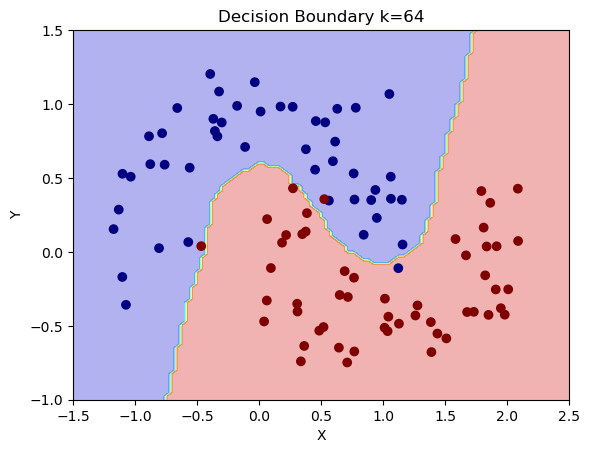

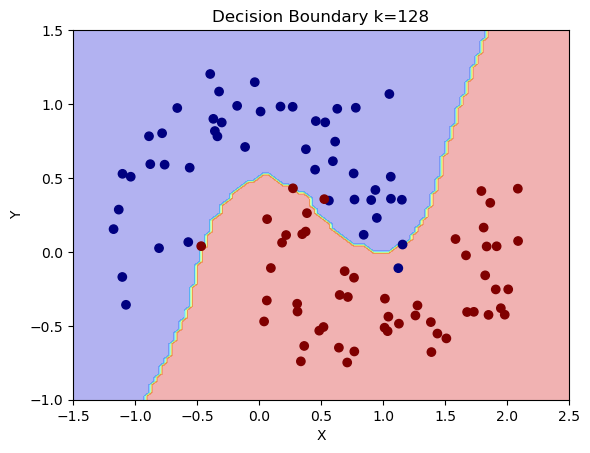

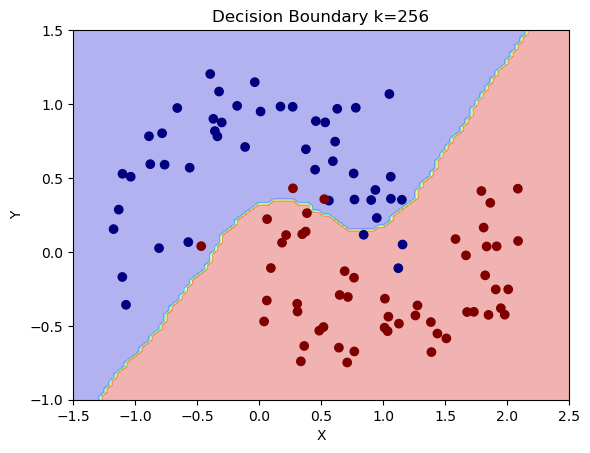

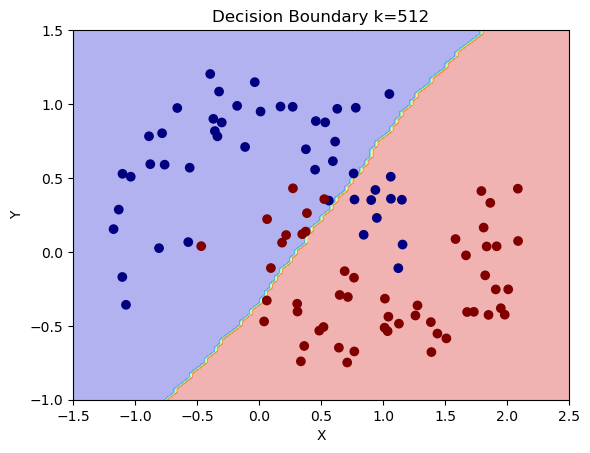

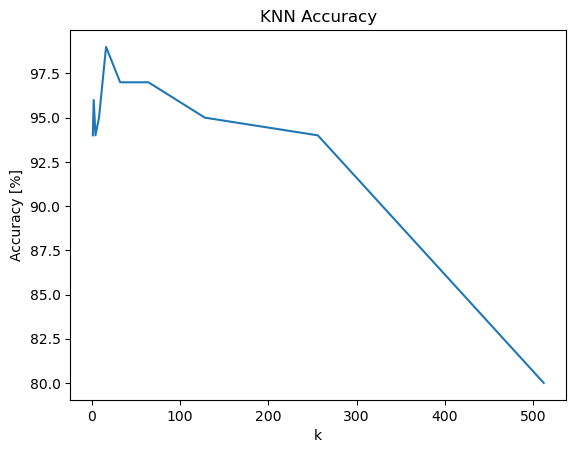

In [7]:
ks = [2**i for i in range(10)]

accuracies = []
accuracies2 = []
for k in ks:
    knn = KNN(k)
    knn.fit(xtrain, ytrain)
    pred = knn.predict(xtest)

    #calculate accuracy
    accuracy = np.mean(pred==ytest)
    accuracies.append(accuracy)

    #get decision boundary
    x1 = np.linspace(-1.5, 2.5, 100)
    x2 = np.linspace(-1.0, 1.5, 100)

    xx, yy = np.meshgrid(x1, x2)
    q = np.stack([xx,yy], axis=2).reshape(-1, 2)
    pred = knn.predict(q).reshape(xx.shape)

    #plot
    plt.figure()
    plt.title("Decision Boundary k={}".format(k))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.contourf(xx, yy, pred, alpha=0.3, cmap=plt.cm.jet)
    plt.scatter(xtest[:,0], xtest[:,1], c=ytest, cmap=plt.cm.jet)
    plt.savefig("ex1_decision_boundary_{}.png".format(k))

plt.figure()
plt.title("KNN Accuracy")
plt.xlabel("k")
plt.ylabel("Accuracy [%]")
plt.plot(ks, np.array(accuracies)*100)
plt.savefig("ex1_accuracy.png")


Accuracy 47.0


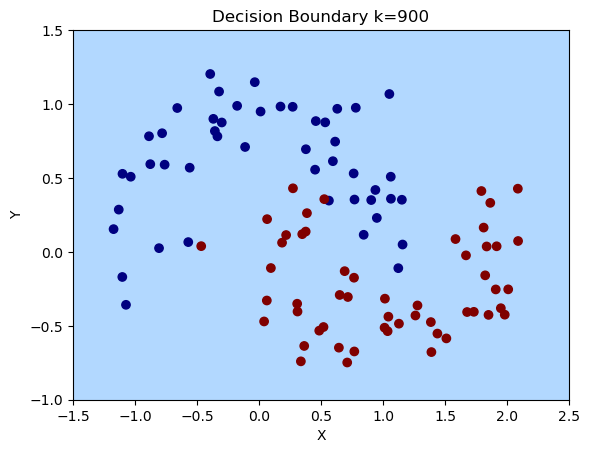

In [8]:
knn = KNN(len(xtrain))
knn.fit(xtrain, ytrain)
pred = knn.predict(xtest)

print("Accuracy", np.mean(pred==ytest)*100)

pred = knn.predict(q).reshape(xx.shape)

plt.figure()
plt.title("Decision Boundary k={}".format(len(xtrain)))
plt.xlabel("X")
plt.ylabel("Y")
plt.contourf(xx, yy, pred, alpha=0.3, cmap=plt.cm.jet)
plt.scatter(xtest[:,0], xtest[:,1], c=ytest, cmap=plt.cm.jet)
plt.savefig("ex1_decision_boundary_{}.png".format(len(xtrain)))

Class probabilities: p(0)=0.503 p(1)=0.497


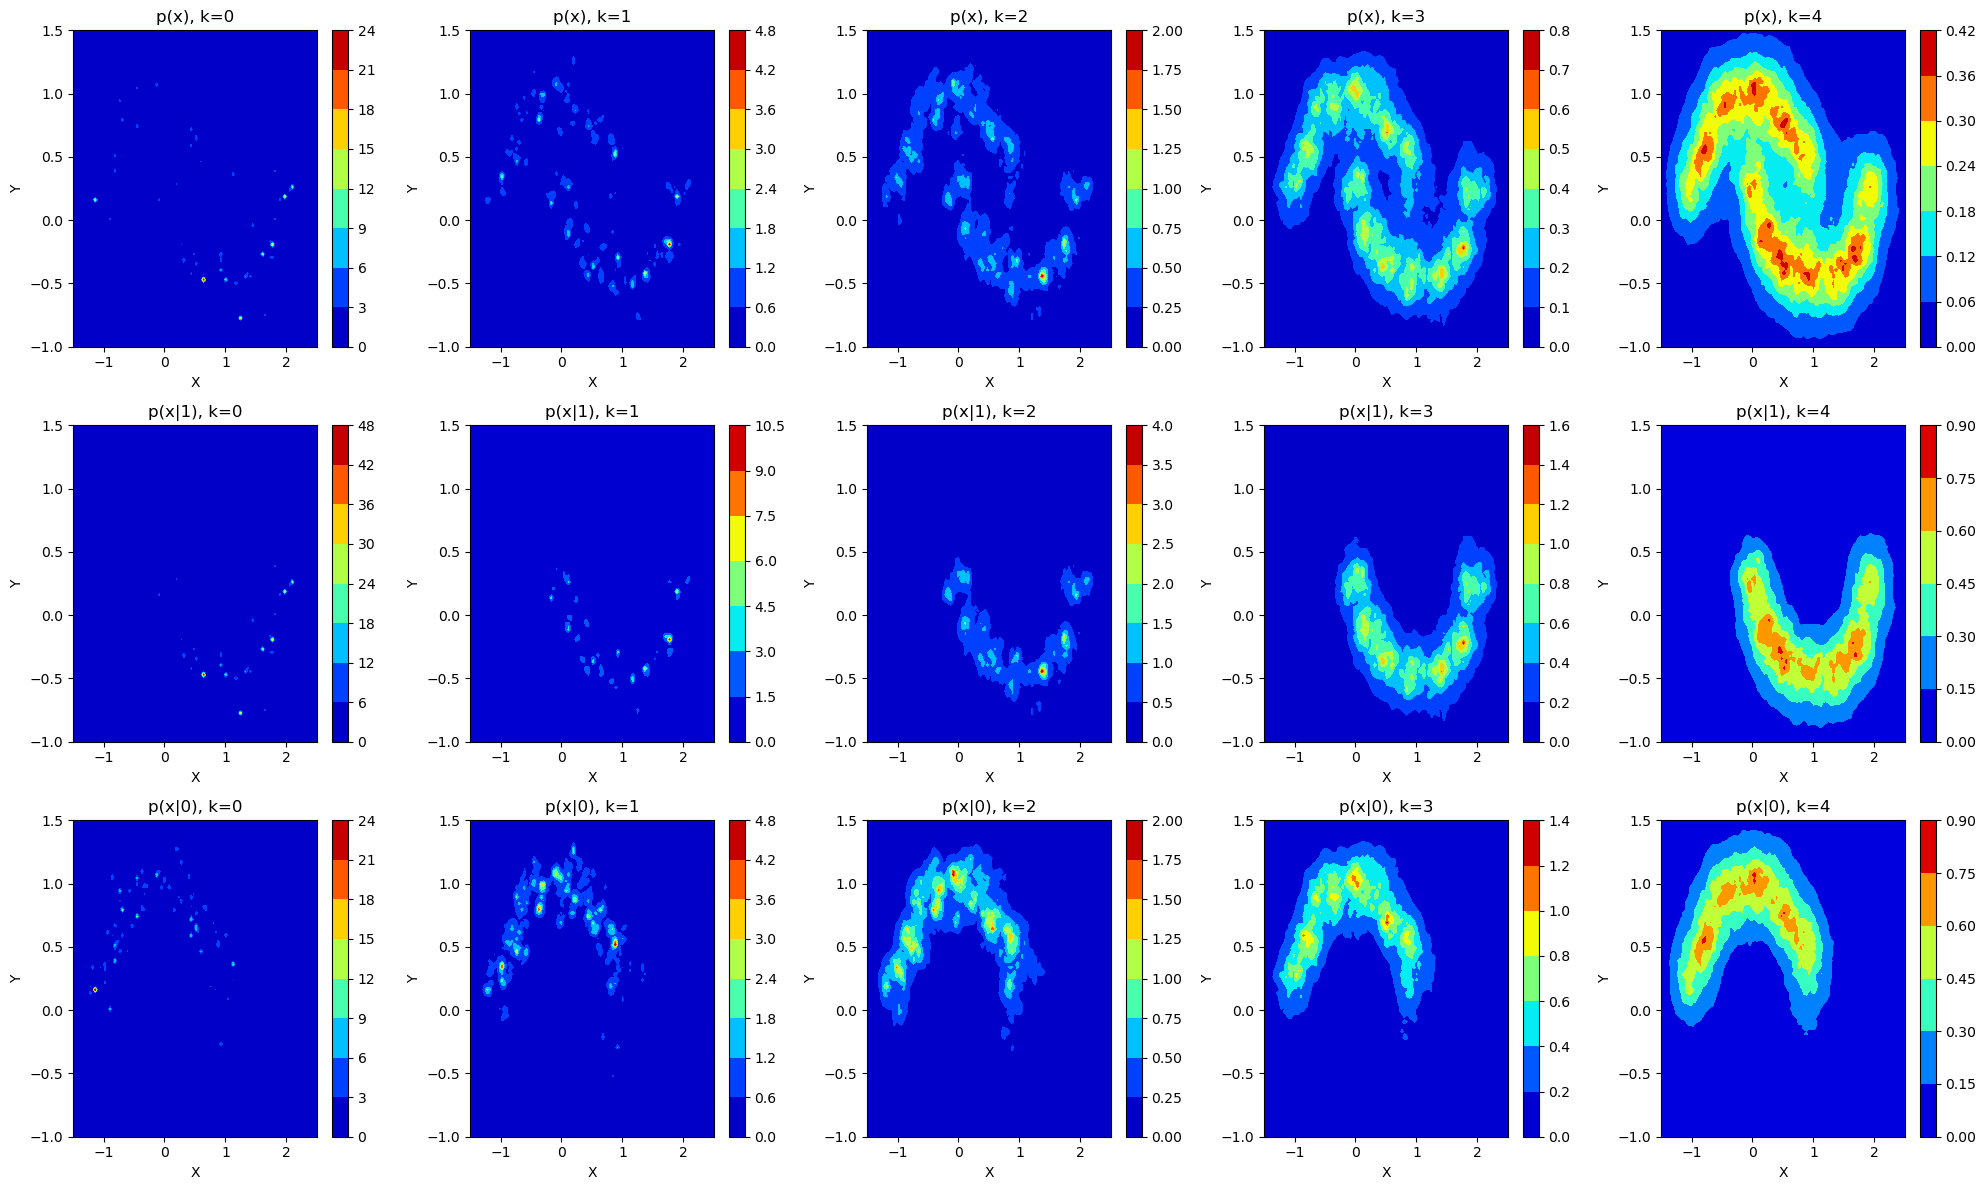

In [20]:
#class probabilities
p0 = np.sum(ytrain==0)/len(ytrain)
p1 = np.sum(ytrain==1)/len(ytrain)
print("Class probabilities: p(0)={:.3f} p(1)={:.3f}".format(p0,p1))

#estimate density (fixed K)
densities = []
densities_0 = []
densities_1 = []
ks = [2,4,8,16,32]
for k in ks:
    knn = KNN(k)
    knn.fit(xtrain, ytrain)
    indices, distances = knn.kneighbours(q)
    radius = distances[:,-1].reshape(xx.shape)

    density = knn.k/knn.x.shape[0]/(np.pi*radius**2)
    densities.append(density)

    classes = np.take(knn.y, indices)
    counts_0 = np.sum(classes==0, axis=1).reshape(xx.shape)
    counts_1 = np.sum(classes==1, axis=1).reshape(xx.shape)

    density = counts_0/np.sum(knn.y==0)/(np.pi*radius**2)
    densities_0.append(density)

    density = counts_1/np.sum(knn.y==1)/(np.pi*radius**2)
    densities_1.append(density)


#estimtate densities
plt.figure(dpi=100, figsize=(20,12))
for i in range(len(ks)):
    plt.subplot(3,len(ks),i+1)
    plt.title("p(x), k={}".format(i))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.contourf(xx,yy, densities[i], cmap=plt.cm.jet)
    plt.colorbar()
for i in range(len(ks)):
    plt.subplot(3,len(ks),i+1+len(ks)*2)
    plt.title("p(x|0), k={}".format(i))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.contourf(xx,yy, densities_0[i], cmap=plt.cm.jet)
    plt.colorbar()
for i in range(len(ks)):
    plt.subplot(3,len(ks),i+1+len(ks))
    plt.title("p(x|1), k={}".format(i))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.contourf(xx,yy, densities_1[i], cmap=plt.cm.jet)
    plt.colorbar()
plt.tight_layout()
plt.savefig("ex1_densities_fixed_k.png")

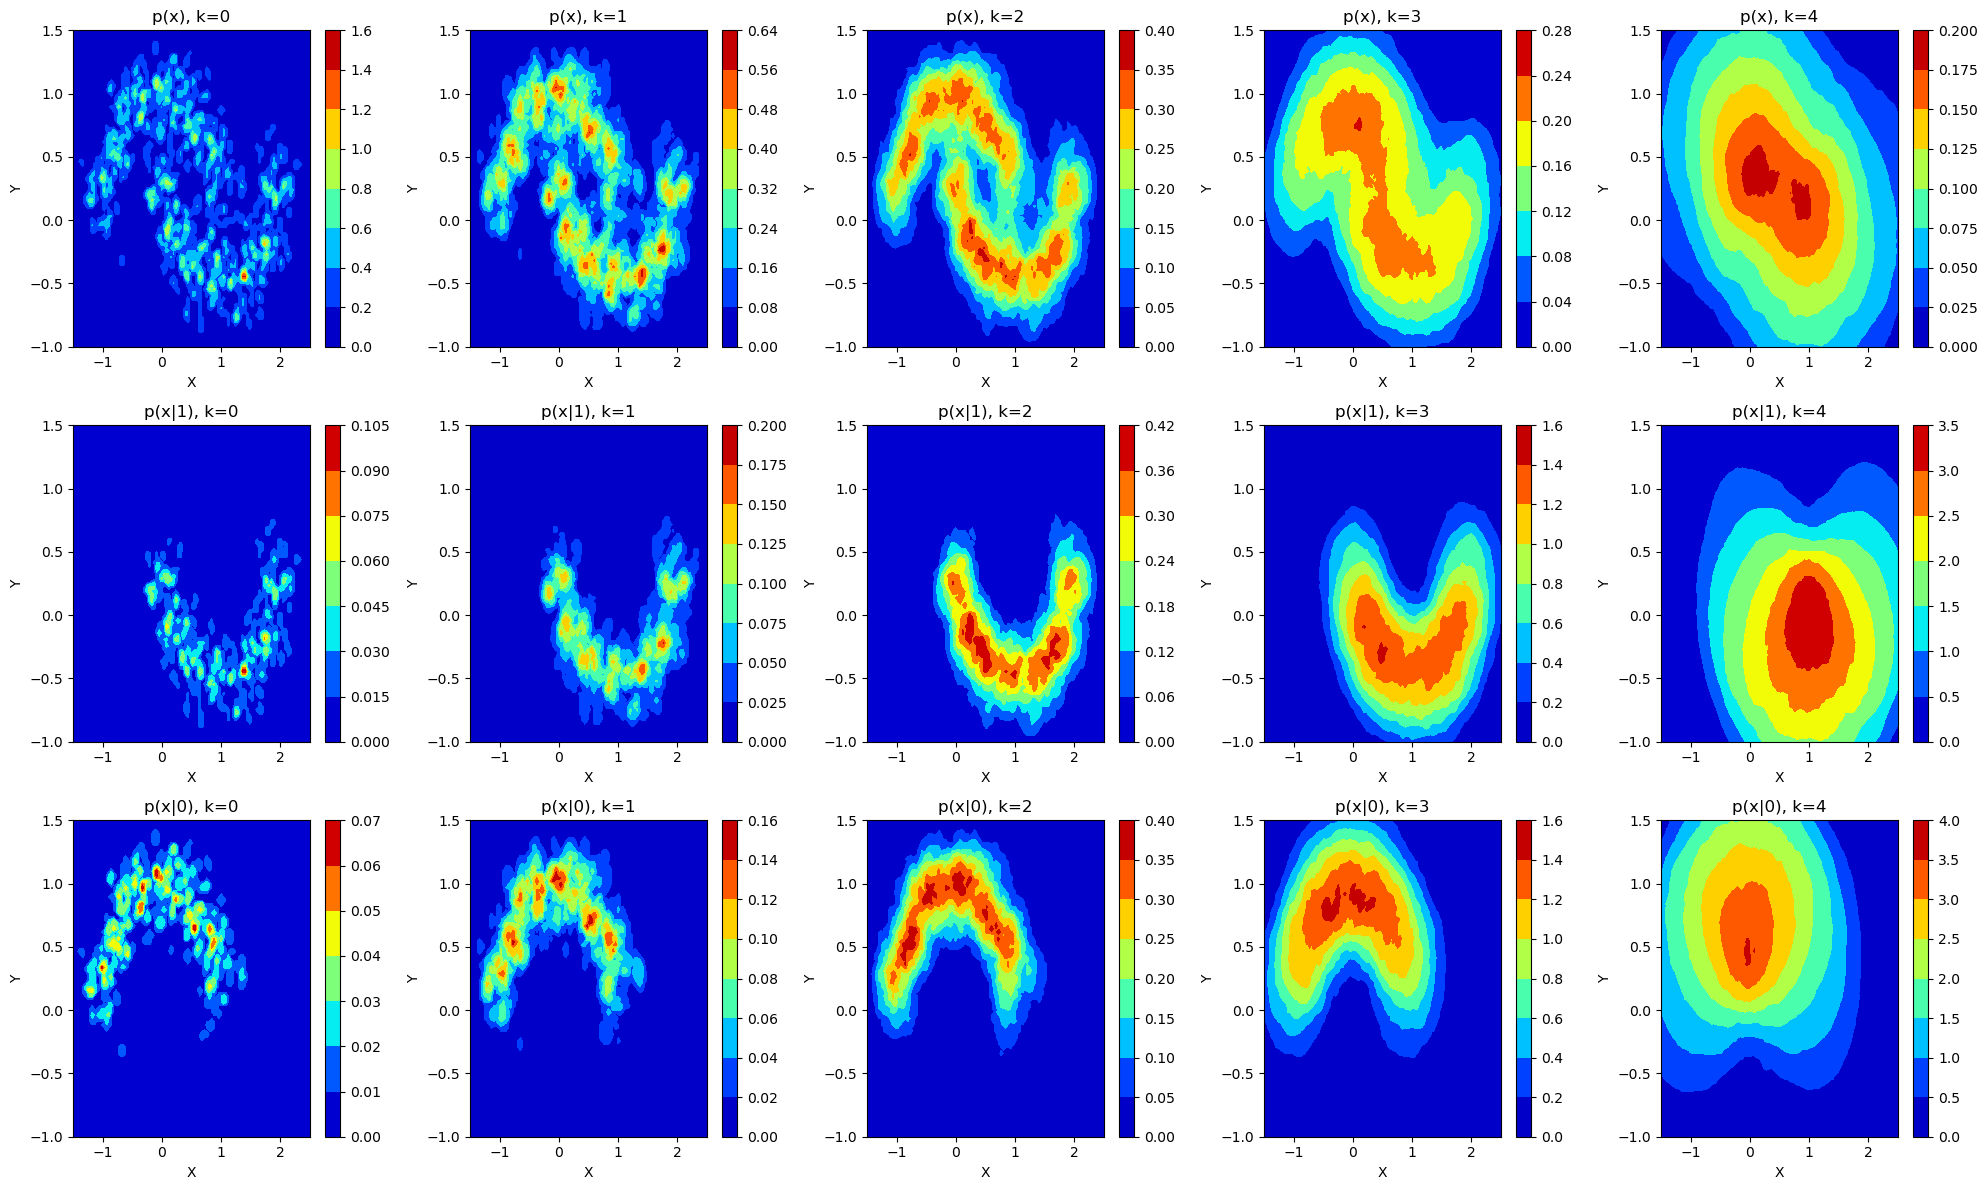

In [19]:
#estimate density (fixed V)
densities = []
densities_0 = []
densities_1 = []
dists = [0.05, 0.1, 0.2, 0.5, 1.0]
knn = KNN(len(xtrain))
knn.fit(xtrain, ytrain)
counts_0 = np.sum(classes==0, axis=1).reshape(xx.shape)
counts_1 = np.sum(classes==1, axis=1).reshape(xx.shape)
for d in dists:
    indices, distances = knn.kneighbours(q)
    classes = np.take(knn.y, indices)

    #function for counting the occurence of classes in a fixed volume
    def count_k(row):
        drow, dclass = np.split(row, 2)
        #first of all clip row to radius
        temp = np.abs(drow-d)
        ind = np.argmin(temp)
        dclass = dclass[:ind+1]
        
        #count per class
        num_class1 = np.sum(dclass==0)
        num_class2 = np.sum(dclass==1)
        return [num_class1, num_class2]
    
    counts = np.apply_along_axis(count_k, axis=1, arr=np.concatenate([distances,classes], axis=-1))
    
    volume = np.pi*d**2
    
    density = np.sum(counts, axis=-1)/(len(xtrain)*volume)
    densities.append(density.reshape(xx.shape))
    
    density_0 = counts[:,0]/len(counts_0*volume)
    densities_0.append(density_0.reshape(xx.shape))
    
    density_1 = counts[:,1]/len(counts_1*volume)
    densities_1.append(density_1.reshape(xx.shape))


#estimtate densities
plt.figure(dpi=100, figsize=(20,12))
for i in range(len(ks)):
    plt.subplot(3,len(ks),i+1)
    plt.title("p(x), k={}".format(i))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.contourf(xx,yy, densities[i], cmap=plt.cm.jet)
    plt.colorbar()
for i in range(len(ks)):
    plt.subplot(3,len(ks),i+1+len(ks)*2)
    plt.title("p(x|0), k={}".format(i))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.contourf(xx,yy, densities_0[i], cmap=plt.cm.jet)
    plt.colorbar()
for i in range(len(ks)):
    plt.subplot(3,len(ks),i+1+len(ks))
    plt.title("p(x|1), k={}".format(i))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.contourf(xx,yy, densities_1[i], cmap=plt.cm.jet)
    plt.colorbar()
plt.tight_layout()
plt.savefig("ex1_densities_const_volume.png")

## Task 2

In [29]:
#function to load dataset
def make_data(noise=0.2, outlier=1):
    prng = np.random.RandomState(0)
    n = 500

    x0 = np.array([0, 0])[None, :] + noise * prng.randn(n, 2)
    y0 = np.ones(n)
    x1 = np.array([1, 1])[None, :] + noise * prng.randn(n, 2)
    y1 = -1 * np.ones(n)

    x = np.concatenate([x0, x1])
    y = np.concatenate([y0, y1]).astype(np.int32)

    xtrain, xtest, ytrain, ytest = train_test_split(
        x, y, test_size=0.1, shuffle=True, random_state=0
    )
    xplot, yplot = xtrain, ytrain

    outlier = outlier * np.array([1, 1.75])[None, :]
    youtlier = np.array([-1])
    xtrain = np.concatenate([xtrain, outlier])
    ytrain = np.concatenate([ytrain, youtlier])
    return xtrain, xtest, ytrain, ytest, xplot, yplot

In [30]:
class LinearLeastSquares:
    def fit(self, x, y):
        #apply bias trick
        x = np.concatenate([x, np.ones_like(x[:,:1])], axis=1)

        self.x = x
        self.y = y

        #implement equation (3)
        xx = np.dot(x.T,x)
        xx_inv = np.linalg.inv(xx)
        self.theta = np.dot(xx_inv, np.dot(x.T, y))

    def predict(self, x):
        #to predict we just need to check on which "side" of 0 we are
        pred = np.dot(np.concatenate([x, np.ones_like(x[:,:1])], axis=1),self.theta)
        pred[pred>=0] = 1
        pred[pred<0] = -1
        return pred

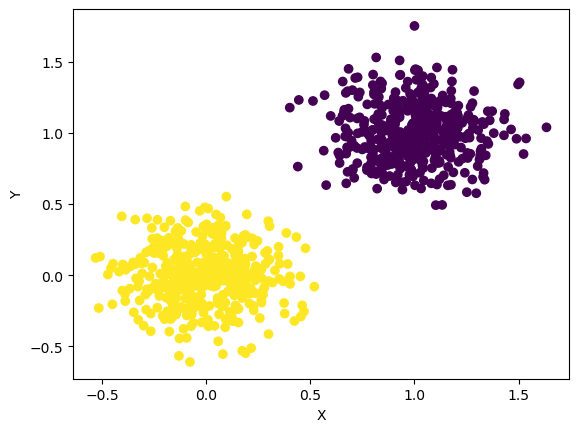

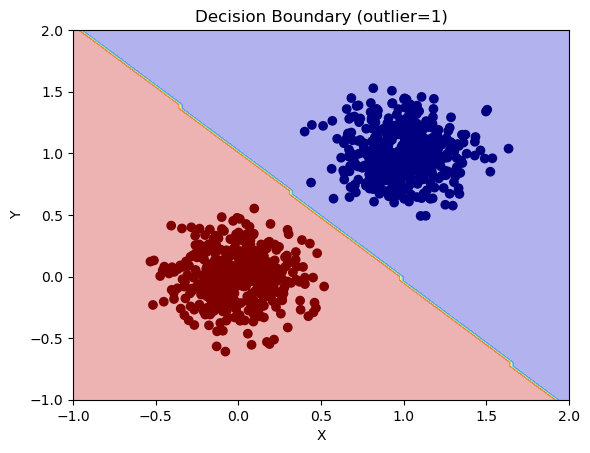

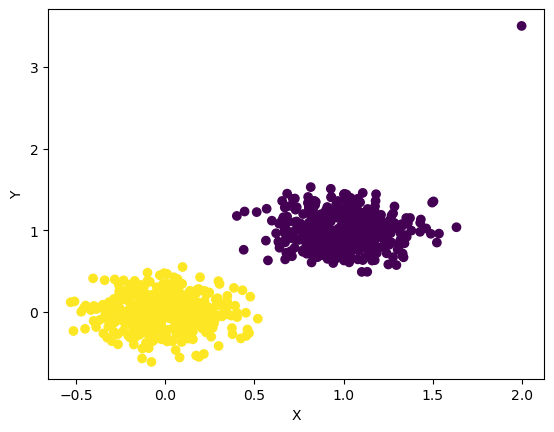

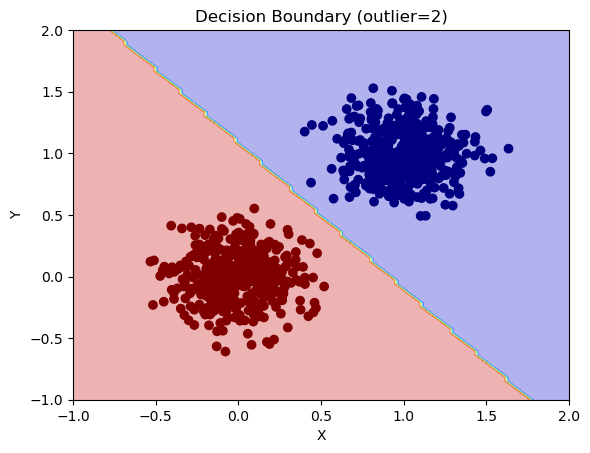

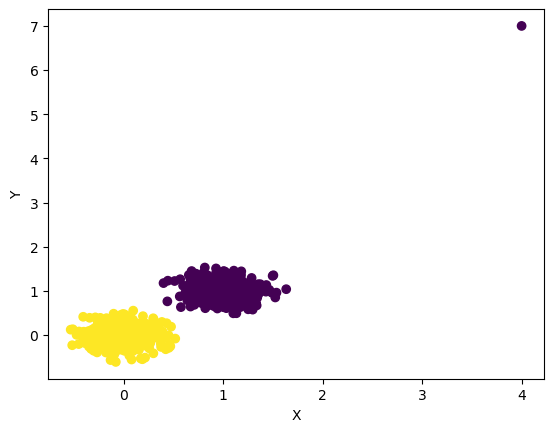

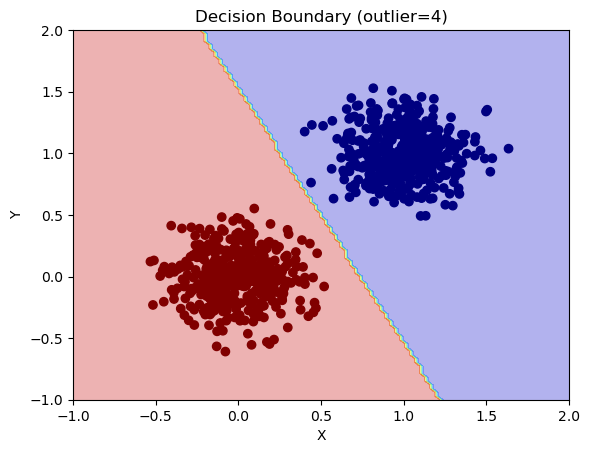

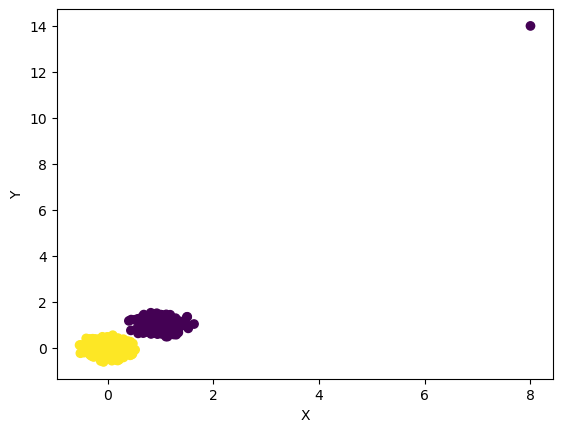

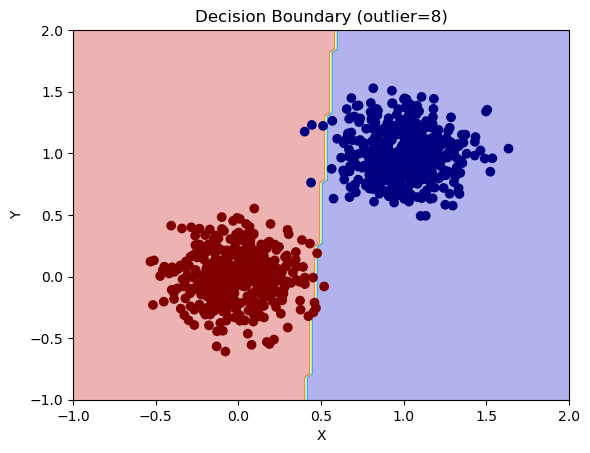

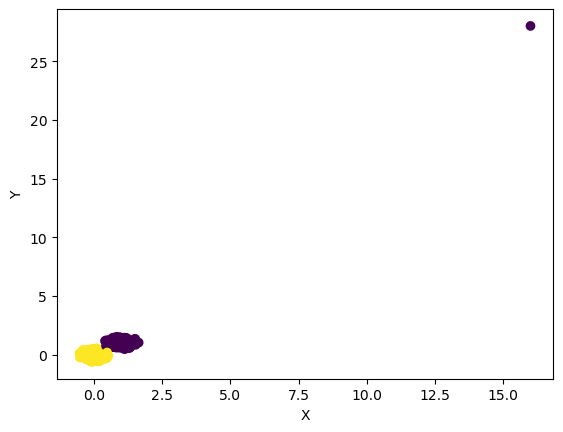

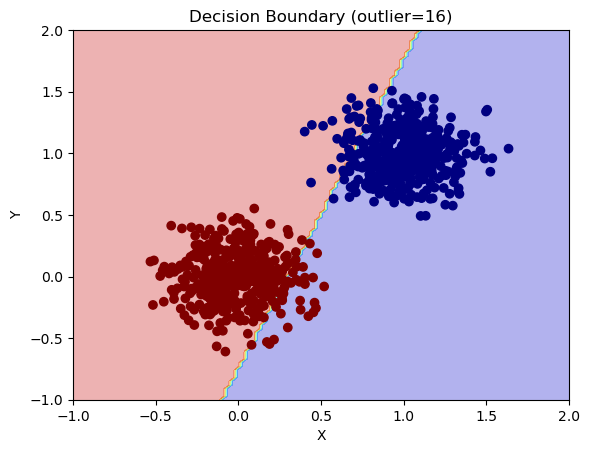

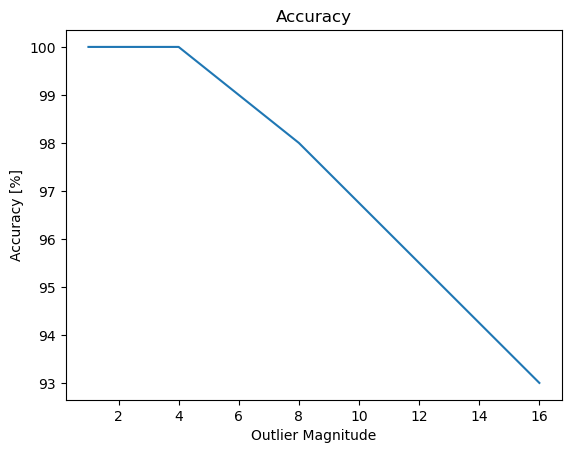

In [31]:
outliers = [1,2,4,8,16]
accuracies = []
for outlier in outliers:
    xtrain, xtest, ytrain, ytest, xplot, yplot = make_data(outlier=outlier)

    plt.figure()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.scatter(xtrain[:,0], xtrain[:,1], c=ytrain)
    plt.savefig("ex2_dataset_{}.png".format(outlier))

    lls = LinearLeastSquares()
    lls.fit(xtrain, ytrain)

    pred = lls.predict(xtest)
    accuracy = np.mean(pred==ytest)
    accuracies.append(accuracy)

    #get decision boundary
    x1 = np.linspace(-1.0, 2.0, 100)
    x2 = np.linspace(-1.0, 2.0, 100)

    xx, yy = np.meshgrid(x1, x2)
    q = np.stack([xx,yy], axis=2).reshape(-1, 2)
    pred = lls.predict(q).reshape(xx.shape)

    plt.figure()
    plt.title("Decision Boundary (outlier={})".format(outlier))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.contourf(xx, yy, pred, alpha=0.3, cmap=plt.cm.jet)
    plt.scatter(xplot[:,0], xplot[:,1], c=yplot, cmap=plt.cm.jet)
    plt.savefig("ex2_decision_boundary_{}.png".format(outlier))

plt.figure()
plt.title("Accuracy")
plt.xlabel("Outlier Magnitude")
plt.ylabel("Accuracy [%]")
plt.plot(outliers, np.array(accuracies)*100)
plt.savefig("ex2_accuracy.png")

    

## Task 3: Softmax Regression & Optimization

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 218.70it/s]


----------------
Gradient Shapes
CE: (1347, 10)
Softmax: (1347, 10)
Weights: (10, 64)
----------------
Final accuracy=96.4%


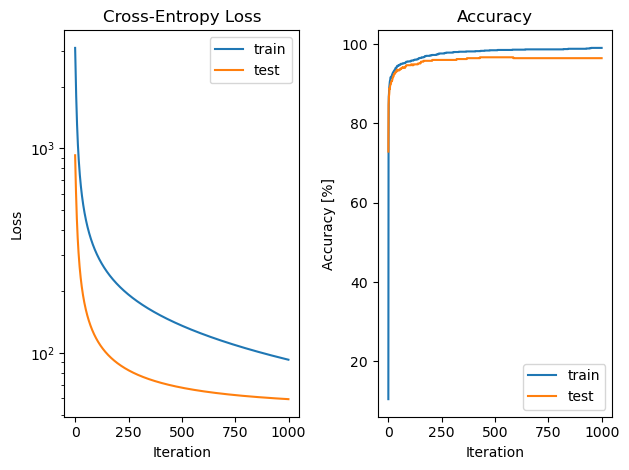

In [32]:
#load dataset
data = load_digits()
x, y = (data.images / 16.0).reshape(-1, 8 * 8), data.target
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=0)


def softmax(logits):
    x = np.exp(logits-np.amax(logits)) #stabilize softmax
    return x/(np.sum(x, axis=1,keepdims=True))

#initialize parameters (10 classes)
weights = np.ones((1,10,x.shape[1])) #add 1 for abtch axis
bias = np.zeros((1,10)) #theta_o

losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []
lr = 1e-3
for i in tqdm(range(1000)):
    #predict
    logits = np.einsum("bji,bi->bj", weights,xtrain)+bias
    probabilities = softmax(logits)

    #calculate one-hot
    onehot = np.eye(10)[ytrain]

    cross_entropy = -np.sum(np.log(probabilities)*onehot) #loss
    losses_train.append(cross_entropy) #log loss

    pred = np.argmax(probabilities, axis=1) #predict: class with highest probability
    accuracies_train.append(np.mean(pred==ytrain))

    #calculate gradients
    grad_ce = np.where(onehot==1,-1.0/probabilities, 0.0) #gradient from cross entropy

    #gradient from softmax
    jacobian = -probabilities[:,:,None]*probabilities[:,None,:] 
    #correct diagonal entries
    jacobian += np.expand_dims(np.eye(probabilities.shape[-1]),axis=0)*np.expand_dims(probabilities, axis=-1).repeat(probabilities.shape[-1], axis=-1)
    grad_softmax = np.einsum("bj,bji->bi", grad_ce, jacobian)
    
    #weights
    grad_bias = np.sum(grad_softmax, axis=0)
    grad_weights = np.sum(np.einsum("bj,bi->bji", grad_softmax, xtrain), axis=0)

    #gradient descent
    weights = weights - lr*grad_weights
    bias = bias - lr*grad_bias


    #do the same for test data
    logits = np.einsum("bji,bi->bj", weights,xtest)+bias
    probabilities = softmax(logits)

    #calcualte one-hot
    onehot = np.eye(10)[ytest]

    cross_entropy = -np.sum(np.log(probabilities)*onehot)
    losses_test.append(cross_entropy)

    pred = np.argmax(probabilities, axis=1)
    accuracies_test.append(np.mean(pred==ytest))

print("----------------")
print("Gradient Shapes")
print("CE:", grad_ce.shape)
print("Softmax:", grad_softmax.shape)
print("Weights:", grad_weights.shape)
print("----------------")


plt.figure()
plt.subplot(1,2,1)
plt.title("Cross-Entropy Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.plot(losses_train, label="train")
plt.plot(losses_test, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy [%]")
plt.plot(np.array(accuracies_train)*100, label="train")
plt.plot(np.array(accuracies_test)*100, label="test")
plt.legend()

plt.tight_layout()
plt.savefig("ex3_accuracy.png")

#calculate accuracy on test set
logits = np.einsum("bji,bi->bj", weights,xtest)+bias
probabilities = softmax(logits)
pred = np.argmax(probabilities, axis=1)
accuracy = np.mean(pred==ytest)
print("Final accuracy={:.3}%".format(accuracy*100.0))
            


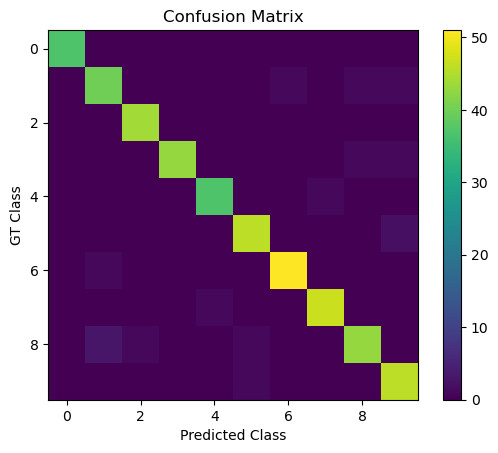

In [33]:
#<this was not asked in the exercise>
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(ytest, pred)

plt.figure()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("GT Class")
plt.imshow(conf_mat)
plt.colorbar()